<img src="logo_UNSAM.jpg" align="right" width="120">


# <center>Trabajo final: Análisis y procesamiento de señales: *Detección de crisis epilépticas mediante análisis de EEG*</center> 

### <center> - Alumna: Lola Pampin</center> 

### <center> - Profesor: Mariano Llamedo Soria</center> 

### <center>Febrero 2026</center> 

## <center> Universidad Nacional de San Martín, Escuela de Ciencia y Tecnología</center> 




# **I. Introducción**
## **Epilepsia** 
La epilepsia es un trastorno neurológico crónico caracterizado por la aparición recurrente de crisis, producto de una actividad neuronal anormal, excesiva o sincrónica en el cerebro. Estas crisis pueden generar consecuencias negativas tanto a corto como a largo plazo, incluyendo caídas, traumatismos, mortalidad prematura, trastornos psiquiátricos, déficits cognitivos y dificultades en el ámbito social, laboral y académico.


El tratamiento disponible puede ser farmacológico o quirúrgico. Sin embargo, los fármacos antiepilépticos presentan efectos adversos y limitaciones en su eficacia, el 30% de pacientes que continúan presentando crisis a pesar de recibir tratamiento adecuado. Por otra parte, la cirugía es una alternativa reservada para un subgrupo específico de epilepsias focales y no constituye una opción viable para todos los pacientes.


En este contexto, la predicción de crisis epilépticas representa una estrategia prometedora, ya que permite anticipar eventos preictales e ictales para implementar medidas preventivas, como preparar el entorno del paciente, activar dispositivos de estimulación neuromodulatoria o administrar fármacos de rescate o acción rápida.


## **Electroencefalograma (EEG)**
El EEG constituye una técnica no invasiva ampliamente utilizada para evaluar la actividad neurofisiológica y posee aplicaciones clínicas esenciales, entre ellas la diferenciación entre crisis epilépticas y eventos no epilépticos, como crisis psicógenas de origen no epiléptico, síncope, trastornos del movimiento subcortical o variantes de migraña.

Tradicionalmente, el análisis del electroencefalograma (EEG) se ha basado en la inspección visual realizada por especialistas. Sin embargo, debido a la complejidad inherente de la señal, resulta útil modelar el EEG como una realización de un proceso estocástico, lo cual permite evaluar sus propiedades estadísticas mediante herramientas propias del análisis de señales aleatorias. Entre estas propiedades se incluyen la distribución de probabilidad, la media, la varianza, las funciones de correlación y el espectro de potencia.

Dado que el EEG presenta variaciones rápidas y locales en el tiempo, es común asumir un régimen de estacionariedad en intervalos cortos, típicamente de alrededor de diez segundos, bajo condiciones de comportamiento estable. En este contexto, el EEG puede analizarse tanto en el dominio del tiempo como en el dominio de la frecuencia. Además, al tratarse de un sistema multicanal, es posible estudiar simultáneamente varias derivaciones y explorar interacciones espaciales entre regiones cerebrales. 


El presente trabajo tiene como objetivo explorar métodos de monitoreo no invasivo y de bajo costo orientados a la predicción y detección temprana de crisis epilépticas. En particular, se abordan enfoques basados en aprendizaje automático aplicados a señales de electroencefalografía (EEG), los cuales utilizan la identificación de patrones y eventos específicos como indicadores preictales. Asimismo, se evalúan métricas de sincronización entre canales de EEG como posibles biomarcadores relevantes para la predicción de crisis.

### Base de datos EEG

La base de datos utilizada recopila información en EDF format (European Data Format) de 14 pacientes de la Unidad de Neurología y Neurofisología de la Universidad de Siena (Italia). Los electrodos se encuentran ubicados según el sistema internacional 10/20.


El sistema de 10/20 internacional es un método estandar para describir la localización de cada uno de los electrodos en un electroencefalograma. Los números 10/20 hacen referencia al porcentaje de distancia en la que deben estar colocados los electrodos en la parte frontal, occipital, de lado derecho e izquierda del cráneo. Cada sitio tiene una letra para identificar el lóbulo y un número para identificar la ubicación del
hemisferio. 


| **ELECTRODE** | **Lóbulo** |
|:-------------:|:----------:|
| F             | Frontal    |
| T             | Temporal   |
| C             | Central    |
| P             | Parietal   |
| O             | Occipital  |


<div style="text-align: center;">
    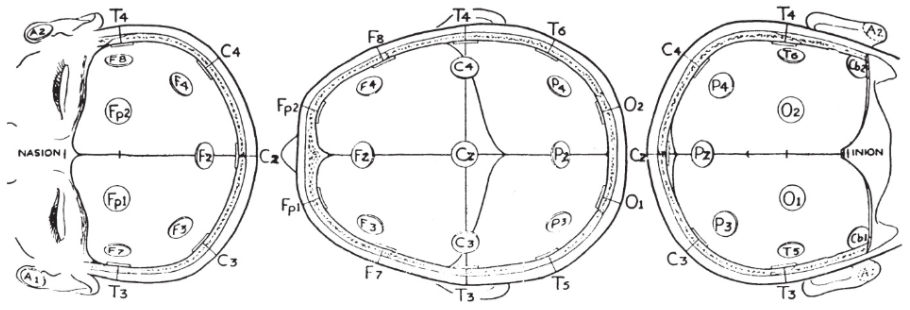<br>
    <div style="font-style: italic;">
        <b>Figura 1.</b> Distribución de electrodos en el sistema 10–20.
    </div>
</div>




Dadas dos series temporales $x_h(t)$ y $x_k(t)$ (por ejemplo, series relacionadas con dos señales de EEG) y una ventana de tiempo $\Delta t\$ que contiene *N* instantes de tiempo, PLI y WPLI pueden definirse de la siguiente manera:

$$
PLI_{h,k,\Delta t} = \left| \frac{1}{N} \sum_{p=1}^{N} \text{sign}(\phi_h(p) - \phi_k(p)) \right|
$$

$$
WPLI_{h,k,\Delta t} = \frac{\left| \frac{1}{N} \sum_{p=1}^{N} \sin(\phi_h(p) - \phi_k(p)) \right|}{\frac{1}{N} \sum_{p=1}^{N} \left| \sin(\phi_h(p) - \phi_k(p)) \right|}
$$

donde $\phi_h(p)$ y $\phi_k(p)$ son las fases en el instante de tiempo 𝑝 de las señales $x_h(t)$ y  $x_k(t)$, respectivamente, determinadas mediante la transformación de Hilbert 




# **II. Métodos**

# **III. Desarrollo**

# **IV. Resultados**

# **V. Conclusiones**